In [10]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import emcee
from astropy.table import Table
import warnings
warnings.filterwarnings('ignore')

In [54]:
def log_likelihood(theta, x, y, xerr, yerr):
    m, b, log_disp = theta
    model = m*x + b
    sigma2 = xerr**2 + yerr**2 + np.exp(2*log_disp)
    return -1.0 * np.sum( ((y - model)**2 / sigma2) + np.log(sigma2) )

def log_prior(theta):
    m, b, log_disp = theta
    if 0.05 < m < 3.5 and -20. < b < 40. and np.log10(0.0001) < log_disp < np.log10(12):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

def mcmc_fit(x, y, xerr, yerr, plot=False):
    #xerr=np.zeros(len(x))
    #yerr=np.zeros(len(y))
    
    #Check of fit for intial guess below
    fit = np.polyfit(x, y, 1)
    
    #to plot on the flux grid
    x0 = np.linspace(x.min(), x.max(), 10)
    
    #First just find ML fit for MCMC initialization
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([0.9, fit[1], np.log(10)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, xerr, yerr))
    m_ml, b_ml, log_disp_ml = soln.x
    
    #Initalize and run MCMC
    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))
    sampler.run_mcmc(pos, 3000, progress=True)
    
    #Remove the "burn-in" period
    tau = sampler.get_autocorr_time()
    try:
        flat_samples = sampler.get_chain(discard=int(2*np.mean(tau)), thin=15, flat=True)
    except ValueError:
        flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    #Plot the results
    if plot:
        inds = np.random.randint(len(flat_samples), size=100)
        for ind in inds:
            sample = flat_samples[ind]
            plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1, zorder=3)
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=yerr, fmt=".b", capsize=0, alpha=0.5)
        m_true = np.percentile(flat_samples[:, 0], [50])
        b_true = np.percentile(flat_samples[:, 1], [50])
        disp_true = np.exp(np.percentile(flat_samples[:, 2], [50]))
        plt.plot(x0, m_true * x0 + b_true, "k", \
                 label="$\gamma=$%.2f, $\\beta=$%.2f, $\delta=$%.2f" % (m_true, b_true, disp_true), \
                 zorder=3)
        plt.legend(fontsize=10)
        plt.xlabel("C$_\mathrm{IV}$ Distance")
        plt.ylabel("$\log{L_{2500Å}}$")
        plt.xlim(-0.3,12)
        plt.ylim(28,35)
        #plt.gca().set_aspect("equal")
        plt.show()
    
    #Return gamma+uncertainties, dispersion
    return np.percentile(flat_samples[:, 0], [16, 50, 84]), np.exp(np.percentile(flat_samples[:, 2], [50]))

def find(x, y, search_params, niter=1, chunk=10, dp=1, cuts="", check=False):
    
    #Return a region of space according to some random cuts
    if niter == 0:
        dust_reddened = (search_params.iloc[:,search_params.columns=="d(g-i)"]>0.3).values.flatten()
        return cuts, search_params[~dust_reddened].index
    
    #Do MCMC fit to get initial dispersion
    if check:
        gamma_curr, disp_curr = mcmc_fit(x, y, np.zeros(len(x)), np.zeros(len(y)))
    
    #Eliminate dust-reddened objects
    dust_reddened = (search_params.iloc[:,search_params.columns=="d(g-i)"]>0.3).values.flatten()
    search_params = search_params[~dust_reddened]
    x = x[~dust_reddened]
    y = y[~dust_reddened]
    
    ind_prop = np.random.randint(search_params.shape[1]) #randomly choose a property to constrain
    name = search_params.columns[ind_prop]
    prop = search_params.iloc[:,ind_prop].values
    #print("Randomly chose to constrain %s" % name)
    
    #We'll randomly choose a range of values for the randomly chosen parameter
    percentiles = np.arange(0, 100+dp, dp)
    #ind_percent = np.random.randint(chunk//dp, len(percentiles)-(chunk//dp))
    ind_percent = np.random.randint(100-chunk//dp)
    l_per, r_per = percentiles[ind_percent], percentiles[ind_percent+chunk//dp]
    l_prop, r_prop = np.percentile(prop, [l_per, r_per])
    
    #Create the mask to cut the data frame
    mask = (prop>=l_prop) & (prop<=r_prop)
    
    if check:
        #Do another MCMC fit with new mask- if dispersion hasn't decreased, reject (how to do that?)
        gamma_new, disp_new = mcmc_fit(x[mask], y[mask], 
                                       np.zeros(len(x[mask])), np.zeros(len(y[mask])))
        if disp_new >= disp_curr:
            print("Rejected cut: %.2f < %s < %.2f" % (l_prop, name, r_prop))
            cuts, cut_indices = find(x, y, search_params, niter, chunk=chunk, dp=dp, cuts=cuts)
        #Cut the data niter times
        else:
            print("Accepted cut: Randomly chose to constrain %s" % name)
            print("Will draw between the %d and %dth percentile: %.2f < %s < %.2f" % (l_per, r_per, l_prop, name, r_prop))
            cuts += ("%.2f < %s < %.2f,"  % (l_prop, name, r_prop))
            cuts, cut_indices = find(x[mask], y[mask], search_params[mask], niter-1, chunk=chunk, dp=dp, cuts=cuts)
    else:
        #print("Will draw between the %d and %dth percentile: %.2f < %s < %.2f" % (l_per, r_per, l_prop, name, r_prop))
        cuts += ("%.2f < %s < %.2f,"  % (l_prop, name, r_prop))
        cuts, cut_indices = find(x[mask], y[mask], search_params[mask], niter-1, chunk=chunk, dp=dp, cuts=cuts)

        
    
    #cut_indices = find(search_params[mask], niter-1)
    return cuts, cut_indices

#def plot_subsample(ax):

In [7]:
dat = pd.read_csv("/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI_wCIVDist.csv")
dat.head()

,Unnamed: 0,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,...,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation,CIV_Dist
0,0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,...,NaN,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.000000e+00,4.569931
1,1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,...,NaN,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,1.144982e-11,5.011265
2,2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,...,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11,5.752605
3,3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,...,NaN,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.000000e+00,4.808101
4,4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,...,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00,3.241830


In [9]:
z = dat[["z_paul"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()
EW   = dat[["CIV_EW"]].values.flatten()
EW_HeII = dat[["HeII_EW"]].values.flatten()
D_GI = dat[["Delta_G_I"]].values.flatten()
good = dat[["good"]].values.flatten()
MI   = dat[["MI"]].values.flatten()
d    = 3.08e19 #cm
L2500= -0.4 * ( MI + 48.60 + 2.5*np.log10(1.+2) ) + np.log10(4*np.pi*(d**2))

fit = np.load("/Users/Trevor1/Desktop/data/files/CIV/bestfit_linear.npy")
CIV_dist = dat[["CIV_Dist"]].values.flatten()

---

It looks like L2500-CIV Distance can be calibrated to some level, but more cuts than are easy to with Bokeh will be necessary.  The simplest ones are cuts on redshift and $\Delta(g-i)$, but additional ones on, e.g., EW or $\Gamma$ will probably help as well.

Write some code that will basically do the exploring for me.  It should be anchored by a function that will choose random areas of a random parameter space and plot where those data points are in L2500-CIV space.

In [12]:
#Create a dataframe we want to traverse through
search_params = np.array([z, D_GI]).T
search_params = pd.DataFrame(search_params, columns=["z", "d(g-i)"])

In [13]:
search_params.columns

Index(['z', 'd(g-i)'], dtype='object')

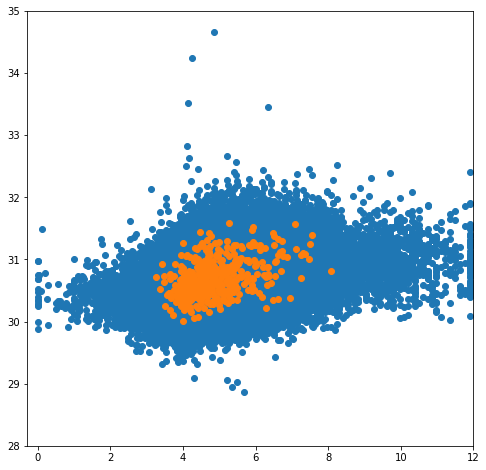

In [70]:
N = 3
subsamples = []
sub_inds = []

for i in range(N):
    cuts, cuts_indices = find(CIV_dist, L2500, search_params, chunk=75, dp=1, niter=20)
    subsamples.append(cuts)
    sub_inds.append(cuts_indices)
    
fig = plt.figure(figsize=(8,8))
for i in range(len(subsamples)):
    if i > 0:
        plt.cla()
    plt.xlim(-0.3,12)
    plt.ylim(28,35)
    plt.scatter(CIV_dist, L2500)
    plt.scatter(CIV_dist[sub_inds[i]], L2500[sub_inds[i]], label=subsamples[i])
    #plt.legend(loc="best")
    #plt.pause(1.0)

#plt.show()

(-2.0, 2.0)

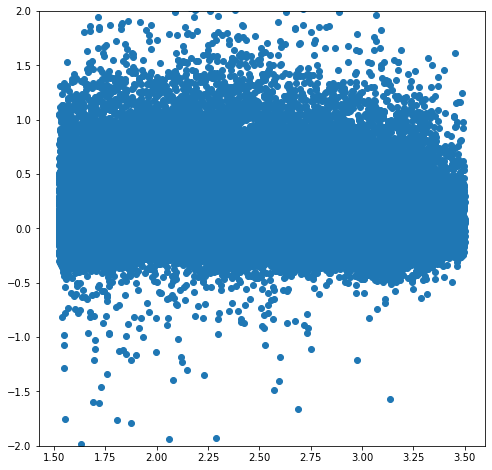

In [18]:
fig = plt.figure(figsize=(8,8))
plt.scatter(z, D_GI)
plt.ylim(-2,2)

In [22]:
nbins = 10
dz = (z.max()-z.min()) / nbins
np.arange(z.min()+(dz/2), z.max(), dz)

array([1.6229116, 1.8204788, 2.018046 , 2.2156132, 2.4131804, 2.6107476,
       2.8083148, 3.005882 , 3.2034492, 3.4010164])

In [25]:
dz

0.1975672

In [31]:
def find_mode(z, D_GI):
    nbins = 10
    dz = (z.max()-z.min()) / nbins
    zbins = np.arange(z.min()+(dz/2), z.max(), dz)
    
    modal_colors = np.zeros(len(zbins))
    for i in range(len(zbins)):
        modal_colors[i] = 3*np.median(D_GI[((z>=(zbins[i]-dz/2))&(z<(zbins[i]+dz/2)))]) - 2*np.mean(D_GI[((z>=(zbins[i]-dz/2))&(z<(zbins[i]+dz/2)))])
    return zbins, modal_colors

(-0.8, 1.8)

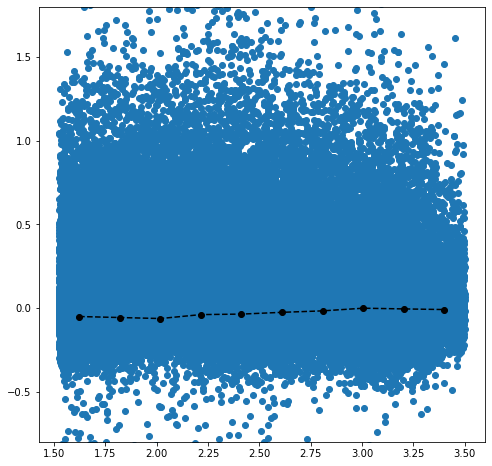

In [32]:
fig = plt.figure(figsize=(8,8))
plt.scatter(z, D_GI)
zbins, modal_colors = find_mode(z, D_GI)
plt.plot(zbins, modal_colors, "--o", color="k")
plt.ylim(-0.8,1.8)

In [33]:
modal_colors

array([-0.05097781, -0.05696668, -0.06303351, -0.03949788, -0.03648082,
       -0.02591884, -0.01719893, -0.00126238, -0.00550956, -0.00936126])